### *Neonympha* classificiation with `pytorch` and `fastai`

Chris Hamm - 2019-09-19 (first code)

I have a lot of photos of *Neonympha* butterflies. Can a CNN tell them apart?

### Preliminaries

Prepare the computing environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
from fastai import *
from fastai.vision import *
batch_size = 64

Set the random seed

In [3]:
np.random.seed(1138)

Read in the data

In [4]:
image_path = '../data/images/'

In [5]:
file_names = get_image_files(image_path)
print(file_names[:4])

[PosixPath('../data/images/Nhe_FL5.JPG'), PosixPath('../data/images/Nmi_1921.JPG'), PosixPath('../data/images/Nmi_1927.JPG'), PosixPath('../data/images/Nfr_4359.JPG')]


Creat the pattern to identify the categories (Nmi, Nfr, Nar, Nhe)

In [6]:
cat_pat = '(N[a-z][a-z])'

In [7]:
image_data = ImageDataBunch.from_name_re(image_path, file_names, \
                                         pat = cat_pat, ds_tfms = get_transforms(), \
                                         size = 224, bs = batch_size)

Normalize the data

In [8]:
image_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (368 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nhe,Nmi,Nfr,Nar,Nmi
Path: ../data/images;

Valid: LabelList (91 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nar,Nar,Nmi,Nmi,Nar
Path: ../data/images;

Test: None

In [9]:
print(image_data.classes)

['Nar', 'Nfr', 'Nhe', 'Nmi']


Print some images

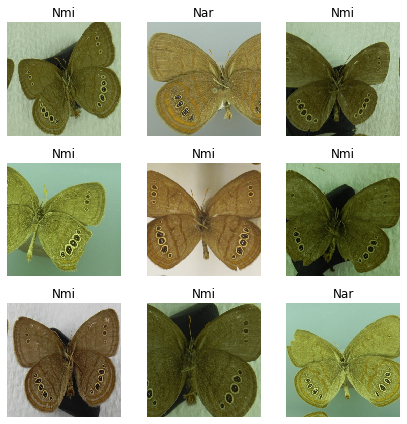

In [10]:
image_data.show_batch(rows = 3, figsize = (6, 6))

In [11]:
len(image_data.classes), image_data.c

(4, 4)

### Train `resnet34`

In [12]:
image_learn = create_cnn(image_data, models.resnet34, metrics = error_rate)

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:09<00:00, 9.28MB/s]


In [13]:
image_learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.984650,0.429884,0.197802,00:17
1,1.196249,0.392780,0.109890,00:15
2,0.910684,0.124388,0.054945,00:14
3,0.705290,0.085703,0.043956,00:15


### Results

In [17]:
interpretation = ClassificationInterpretation.from_learner(image_learn)

losses, idxs = interpretation.top_losses()

len(image_data.valid_ds) == len(losses) == len(idxs)

True

Save the model

In [30]:
image_learn.save('light_model_1')

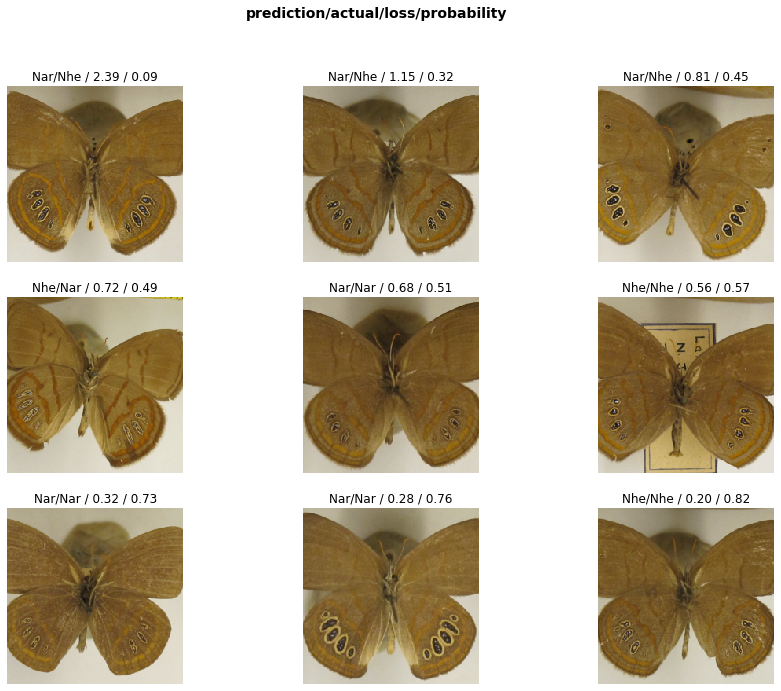

In [20]:
interpretation.plot_top_losses(9, figsize = (15, 11))

In [21]:
# doc(interpretation.plot_top_losses)

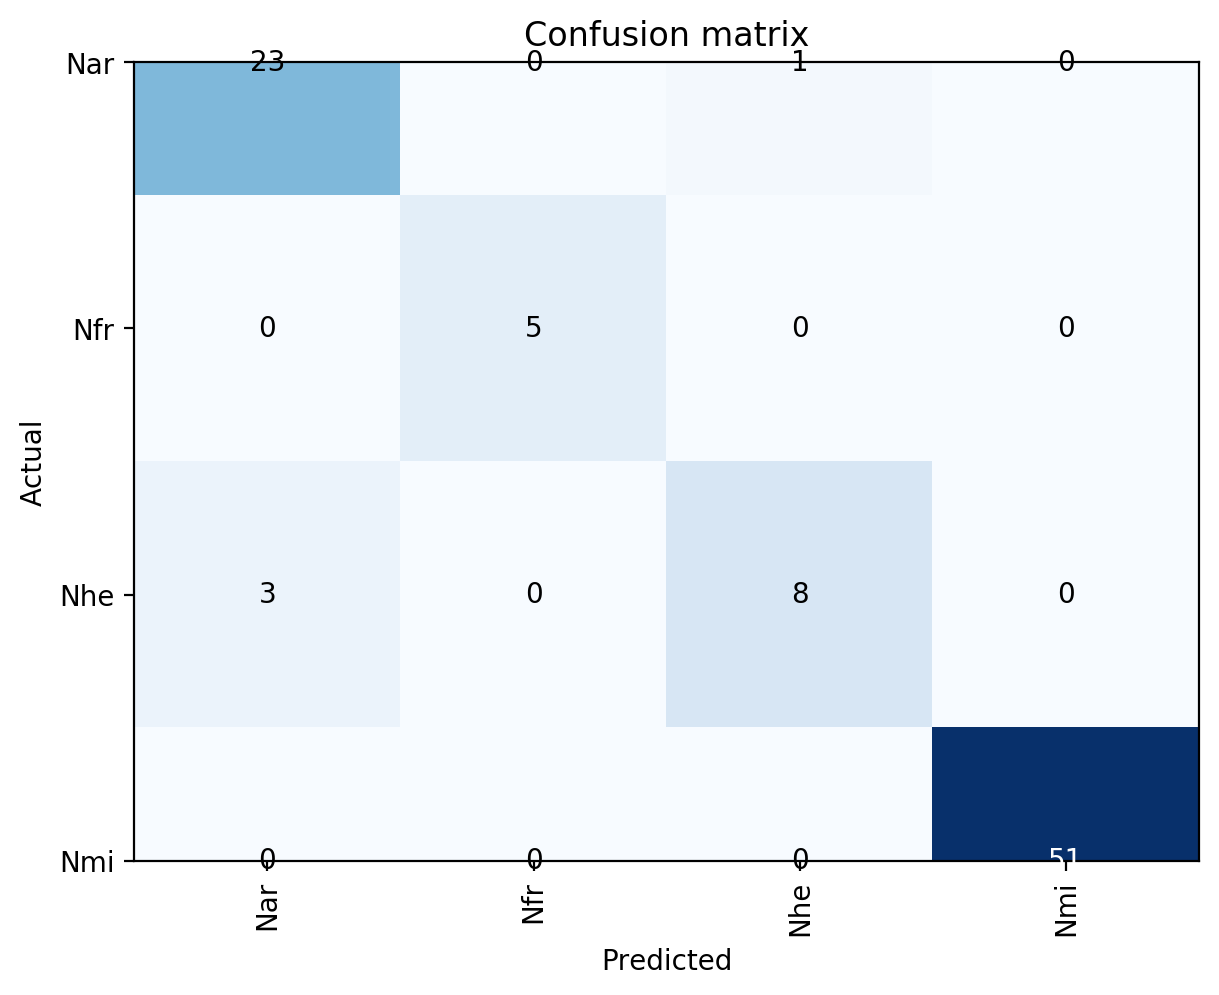

In [24]:
interpretation.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [26]:
interpretation.most_confused(min_val=2)

[('Nhe', 'Nar', 3)]

### Unfreezing, fine-tuning, and learning rates

In [27]:
image_learn.unfreeze()
image_learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.221315,0.385057,0.098901,00:15


In [31]:
image_learn.load('light_model_1')

Learner(data=ImageDataBunch;

Train: LabelList (368 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nhe,Nmi,Nfr,Nar,Nmi
Path: ../data/images;

Valid: LabelList (91 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nar,Nar,Nmi,Nmi,Nar
Path: ../data/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [32]:
# Need to add validation set
image_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
image_learn.recorder.plot()